# 项目架构

project_root/  
│  
├── data/  
│   ├── test_data/              # 测试数据  
│   ├── train_data/        # 训练数据  
│   └── datasets.py       # 数据集类的定义以及数据集加载和预处理的相关函数   
│  
├── models/               
│   └── network.py        # 网络结构的定义  
│  
├── *notebook             # 具体任务处理文件  
│  
├── saved_models/         # 存放保存的模型  
│  
├── README.md             # 项目说明文档  
│  
└── requirements.txt      # Python依赖包清单  

In [82]:
import os
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

# 数据观察

arr= [-11.512925  -11.512925  -11.512925  -11.512925  -11.512925  -11.512925
 -11.512925  -11.512925  -11.512925  -11.512925  -11.512925  -11.512925
 -11.512925  -11.512925  -11.512925  -11.512925  -11.512925  -11.512925
 -11.512925  -11.512925  -11.512925  -11.512925  -11.512925  -11.512925
 -11.512925  -11.512925  -11.512925  -11.512925  -11.512925  -11.512925
  -8.26913    -7.643115   -6.8944025  -6.9186683  -7.045759   -6.59627
  -6.4302588  -7.148154   -7.345049   -7.9891825  -7.7868886  -5.4560966
  -5.116675   -5.7402625  -7.03665    -6.5713353  -6.075513   -4.883743
  -4.5953717  -5.4326143  -4.6503463  -4.2516294  -4.480215   -4.6260505
  -4.5314355  -4.7436     -4.9688187  -5.2853174  -5.620813   -5.775264
  -4.595933   -3.6754465  -3.0953114  -2.9207292  -2.9564226  -3.0343204
  -3.16036    -3.3613453  -3.801488   -4.6245494  -5.881345   -5.9391255
  -4.686872   -4.4067187  -4.636505   -5.4663486  -5.4257812  -6.2835135
  -8.234666   -8.921616   -9.91842   -10.2683525 -10.29

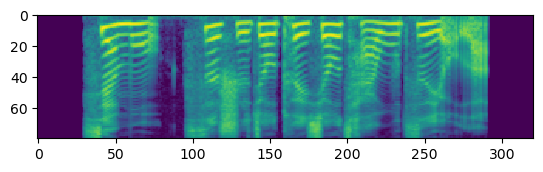

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os
arr=np.load("data/train_data/language_0/F001_010.npy")
print('arr=',arr[:,20])
print('shape=',arr.shape)
plt.imshow(arr.T, cmap='viridis', interpolation='nearest')


In [84]:
import os
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

# 构造数据集类

In [85]:
%%writefile data/datasets.py

import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 定义一个MelFrequencyDataset数据集类
class MelFrequencyDataset(Dataset):
    def __init__(self, data_dir, max_seq_length=300):
        self.data = []
        self.labels = []
        self.max_seq_length = max_seq_length
        label_folders = os.listdir(data_dir)
        for label_folder in label_folders:
            label = 0 if label_folder=='language_0' else 1  # 文件夹名字即为标签
            record_path = os.path.join(data_dir, label_folder)
            for file in os.listdir(record_path):
                file_path = os.path.join(record_path, file)
                self.data.append(file_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]
        # 加载梅尔频率数据
        mel_data = np.load(file_path)  # 假设是.npy格式的文件
        # 对数据进行填充或截断
        if mel_data.shape[0] < self.max_seq_length:
            # 填充到最大长度
            pad_length = self.max_seq_length - mel_data.shape[0]
            mel_data = np.pad(mel_data, ((0, pad_length), (0, 0)), mode='constant', constant_values=0)
        elif mel_data.shape[0] > self.max_seq_length:
            # 截断到最大长度
            mel_data = mel_data[:self.max_seq_length, :]
        # 将梅尔频率特征转换为PyTorch张量并返回
        return torch.tensor(mel_data), torch.tensor(label)

Overwriting data/datasets.py


In [86]:
##### 检查数据集类定义是否有效 #####
dataset = MelFrequencyDataset(data_dir='data/train_data')
# 查看前几个样本
for i in range(5):
    sample, label = dataset[i]
    print(sample.shape, label)

torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)
torch.Size([300, 80]) tensor(1)


# 构造模型类

In [87]:
%%writefile models/network.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class MelRNN(nn.Module):
    def __init__(self, input_size=80, hidden_size=128, num_layers=2, num_classes=2):
        super(MelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)  # 初始化隐藏状态
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # 取RNN最后一个时间步的输出作为模型的输出
        return out
    
class MelTransformer(nn.Module):
    def __init__(self, input_size=80, hidden_size=128, num_layers=10, num_classes=2):
        super(MelTransformer, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model=input_size, nhead=4, dim_feedforward=hidden_size, dropout=0.1)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # 将输入变换为 (seq_len, batch, input_size) 的格式
        output = self.transformer_encoder(x)
        output = output.permute(1, 0, 2)  # 变换回原始的维度顺序
        output = self.fc(output[:, -1, :])  # 取Transformer最后一个时间步的输出作为模型的输出
        return output




Overwriting models/network.py


In [88]:
##### 验证模型类定义是否有效 ##### 
dataset = MelFrequencyDataset(data_dir='data/train_data')
# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 创建数据加载器
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
# 实例化神经网络模型
model = MelTransformer().to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 训练神经网络
model.train()
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print("loss:",loss.item())
    # 计算准确率
    _, predicted = torch.max(outputs, 1)
    correct = (predicted.cpu() == labels.cpu()).sum().item()
    print("acc:",correct/len(inputs))

loss: 0.8877968192100525
acc: 0.4765625
loss: 1.189063549041748
acc: 0.4765625
loss: 0.6992608308792114
acc: 0.4921875
loss: 0.8546091318130493
acc: 0.5078125
loss: 0.9087362289428711
acc: 0.40625
loss: 0.7155560851097107
acc: 0.4765625
loss: 0.7032610177993774
acc: 0.4375
loss: 0.7232986688613892
acc: 0.5078125
loss: 0.7444224953651428
acc: 0.484375
loss: 0.6941920518875122
acc: 0.546875
loss: 0.721411943435669
acc: 0.5
loss: 0.7064810395240784
acc: 0.46875
loss: 0.7018910646438599
acc: 0.4609375
loss: 0.6925854086875916
acc: 0.515625
loss: 0.7155420780181885
acc: 0.453125
loss: 0.7231435775756836
acc: 0.4765625
loss: 0.7416023015975952
acc: 0.4375
loss: 0.7155144810676575
acc: 0.484375
loss: 0.698553740978241
acc: 0.4921875
loss: 0.6878657937049866
acc: 0.546875
loss: 0.7036954760551453
acc: 0.421875
loss: 0.6958209872245789
acc: 0.5546875
loss: 0.7026269435882568
acc: 0.484375
loss: 0.6995205879211426
acc: 0.5
loss: 0.7193268537521362
acc: 0.4609375
loss: 0.7025166749954224
acc: 0.4

# 训练模型

In [89]:
# 实例化数据集
dataset = MelFrequencyDataset(data_dir='data/train_data')

# 划分数据集为训练集和验证集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化神经网络模型
model = MelTransformer().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 注册一个钩子来监测梯度
def gradient_monitoring_hook(module, input_grad, output_grad):
    print('梯度的均值:', input_grad[0].mean().item())
    print('梯度的标准差:', input_grad[0].std().item())

In [90]:
# 训练神经网络
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0  # 用于累积每个epoch的损失
    epoch_correct = 0  # 用于累积每个epoch的正确预测数
    epoch_total = 0  # 用于累积每个epoch的样本总数
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)  # 累积损失
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == labels).sum().item()  # 累积正确预测数
        epoch_total += labels.size(0)  # 累积样本总数
    # 计算每个epoch的平均损失和准确率
    epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_acc = epoch_correct / epoch_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

Epoch [1/40], Loss: 0.7184, Acc: 0.5034
Epoch [2/40], Loss: 0.7000, Acc: 0.4866
Epoch [3/40], Loss: 0.6938, Acc: 0.5150
Epoch [4/40], Loss: 0.6809, Acc: 0.5531
Epoch [5/40], Loss: 0.6567, Acc: 0.5819
Epoch [6/40], Loss: 0.6635, Acc: 0.5750
Epoch [7/40], Loss: 0.6585, Acc: 0.5962
Epoch [8/40], Loss: 0.6392, Acc: 0.6288
Epoch [9/40], Loss: 0.5882, Acc: 0.6872
Epoch [10/40], Loss: 0.5926, Acc: 0.6966
Epoch [11/40], Loss: 0.5784, Acc: 0.6906
Epoch [12/40], Loss: 0.5354, Acc: 0.7341
Epoch [13/40], Loss: 0.5054, Acc: 0.7541
Epoch [14/40], Loss: 0.4608, Acc: 0.7850
Epoch [15/40], Loss: 0.4285, Acc: 0.8147
Epoch [16/40], Loss: 0.4188, Acc: 0.8025
Epoch [17/40], Loss: 0.2953, Acc: 0.8738
Epoch [18/40], Loss: 0.2456, Acc: 0.8966
Epoch [19/40], Loss: 0.2716, Acc: 0.8819
Epoch [20/40], Loss: 0.2007, Acc: 0.9231
Epoch [21/40], Loss: 0.1926, Acc: 0.9200
Epoch [22/40], Loss: 0.1377, Acc: 0.9519
Epoch [23/40], Loss: 0.1404, Acc: 0.9459
Epoch [24/40], Loss: 0.1322, Acc: 0.9509
Epoch [25/40], Loss: 0.12

# 在验证集上测试

In [91]:
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入数据和标签移动到设备上
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.9675


# 保存模型

In [93]:
# 保存模型
# torch.save(model.state_dict(), 'saved_models/'+'model_tfm_v4.pth')